# NDS Evaluation Graph Classification Benchmarks

**Dataset**: MUTAG_mini (18 molecular graphs, binary classification)

This notebook demonstrates how the NDS Evaluation pipeline converts raw graph classification benchmark data into a standardized `exp_sel_data_out` schema format. Each graph becomes one example with:
- **input**: JSON string of graph structure (`num_nodes`, `edge_list`, `node_features`)
- **output**: class label as string
- **metadata**: fold assignment, feature dimensions, number of classes, task type, fold type

**Source**: PyTorch Geometric (TUDataset)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All core logic uses stdlib only (json, collections)
# matplotlib + networkx needed for visualization cell

# Core packages: pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
from collections import Counter

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/dataset_iter1_nds_evaluation/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
raw_data = load_data()
print(f"Loaded {len(raw_data)} dataset object(s)")
for ds in raw_data:
    print(f"  {ds['dataset_name']}: {len(ds['graphs'])} graphs, "
          f"{ds['num_classes']} classes, feature_dim={ds['feature_dim']}")

Loaded 1 dataset object(s)
  MUTAG_mini: 18 graphs, 2 classes, feature_dim=7


## Configuration

Since this is a pure data conversion pipeline (no ML training), the main tunable parameter is how many graphs to process per dataset.

In [5]:
# --- Config ---
# Maximum number of graphs to process per dataset (None = all)
MAX_GRAPHS_PER_DATASET = None  # Demo has 18 graphs total, process all

## Graph-to-Example Conversion

The core conversion function transforms each raw graph dictionary into the standardized schema format. The `input` field becomes a compact JSON string of the graph structure, and metadata fields capture fold assignment, feature dimensions, and classification task properties.

In [6]:
def convert_graph_to_example(graph: dict, dataset_meta: dict) -> dict:
    """Convert a single graph dict to an example in the schema format."""
    # Build input: JSON string of the graph structure
    graph_input = {
        "num_nodes": graph["num_nodes"],
        "edge_list": graph["edge_list"],
        "node_features": graph["node_features"],
    }
    input_str = json.dumps(graph_input, separators=(",", ":"))

    # Build output: label as string
    output_str = str(graph["label"])

    # Build example with metadata
    example = {
        "input": input_str,
        "output": output_str,
        "metadata_fold": graph["fold"],
        "metadata_row_index": graph["id"],
        "metadata_task_type": "graph_classification",
        "metadata_n_classes": dataset_meta["num_classes"],
        "metadata_feature_dim": dataset_meta["feature_dim"],
        "metadata_has_node_features": dataset_meta["has_node_features"],
        "metadata_num_nodes": graph["num_nodes"],
        "metadata_num_edges": len(graph["edge_list"]),
        "metadata_fold_type": dataset_meta["fold_type"],
        "metadata_num_folds": dataset_meta["num_folds"],
    }

    return example

## Dataset Conversion

Process each dataset object: iterate over its graphs, convert each to the schema format, and collect results with summary statistics.

In [7]:
def convert_dataset(dataset_obj: dict) -> dict:
    """Convert one dataset object to the schema format."""
    dataset_name = dataset_obj["dataset_name"]
    graphs = dataset_obj["graphs"]

    # Apply MAX_GRAPHS_PER_DATASET limit
    if MAX_GRAPHS_PER_DATASET is not None:
        graphs = graphs[:MAX_GRAPHS_PER_DATASET]

    print(f"  Converting {dataset_name}: {len(graphs)} graphs...")

    examples = []
    for graph in graphs:
        example = convert_graph_to_example(graph, dataset_obj)
        examples.append(example)

    return {
        "dataset": dataset_name,
        "examples": examples,
    }

## Run Conversion

Convert all datasets and build the output object with metadata.

In [8]:
print("=" * 60)
print("Converting raw graph data → exp_sel_data_out schema")
print("=" * 60)

# Convert each dataset
datasets = []
total_examples = 0
for ds_obj in raw_data:
    converted = convert_dataset(ds_obj)
    datasets.append(converted)
    total_examples += len(converted["examples"])

# Build output object with top-level metadata
output = {
    "metadata": {
        "description": "NDS Evaluation Graph Classification Benchmarks",
        "source": "PyTorch Geometric (GNNBenchmarkDataset, TUDataset)",
        "num_datasets": len(datasets),
        "total_examples": total_examples,
        "random_seed": 42,
    },
    "datasets": datasets,
}

print(f"\nTotal: {total_examples} examples across {len(datasets)} dataset(s)")

Converting raw graph data → exp_sel_data_out schema
  Converting MUTAG_mini: 18 graphs...

Total: 18 examples across 1 dataset(s)


## Summary

Print a summary table of the converted datasets and inspect a sample converted example.

In [9]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
for ds in datasets:
    n_ex = len(ds["examples"])
    ex0 = ds["examples"][0]
    input_len = len(ex0["input"])
    labels = Counter(ex["output"] for ex in ds["examples"])
    print(f"  {ds['dataset']:20s} | {n_ex:5d} examples "
          f"| input_len={input_len:6d} chars "
          f"| labels={dict(labels)}")
print(f"\n  Total examples: {total_examples}")

# Show a sample converted example
print("\n" + "=" * 60)
print("SAMPLE CONVERTED EXAMPLE")
print("=" * 60)
sample = datasets[0]["examples"][0]
for key, val in sample.items():
    if key == "input":
        print(f"  {key}: <{len(val)} chars JSON string>")
    else:
        print(f"  {key}: {val}")

SUMMARY
  MUTAG_mini           |    18 examples | input_len=   616 chars | labels={'0': 6, '1': 12}

  Total examples: 18

SAMPLE CONVERTED EXAMPLE
  input: <616 chars JSON string>
  output: 0
  metadata_fold: 5
  metadata_row_index: 0
  metadata_task_type: graph_classification
  metadata_n_classes: 2
  metadata_feature_dim: 7
  metadata_has_node_features: True
  metadata_num_nodes: 13
  metadata_num_edges: 28
  metadata_fold_type: stratified_10fold_cv
  metadata_num_folds: 10


## Visualization

Visualize graph structures and dataset statistics: (1) sample graph topology, (2) node count distribution, (3) edge count distribution, and (4) class label distribution.

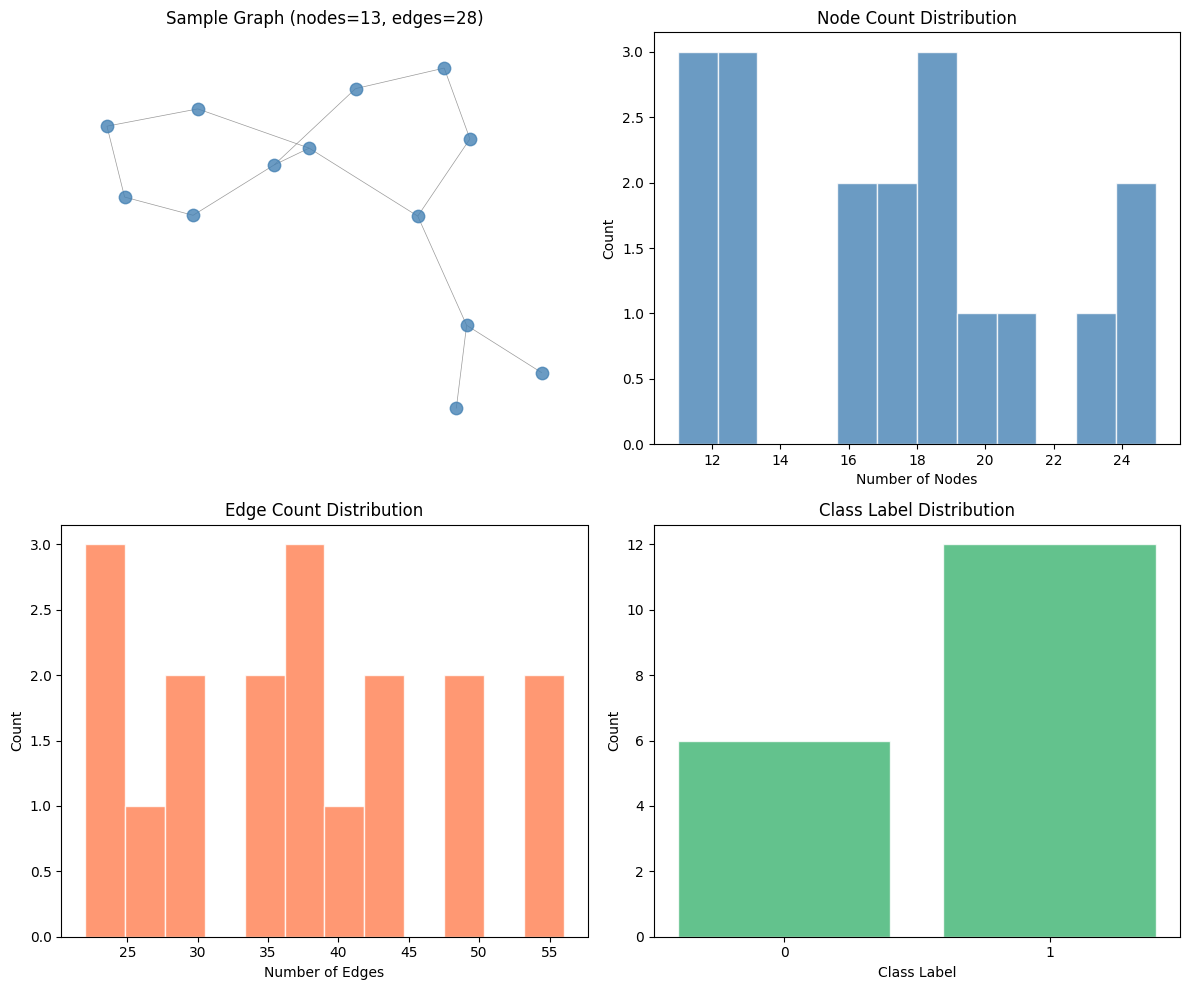

Saved: graph_benchmarks_overview.png


In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Collect all examples across datasets for plotting
all_examples = []
for ds in datasets:
    for ex in ds["examples"]:
        all_examples.append(ex)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Plot 1: Sample graph visualization ---
ax = axes[0, 0]
sample_ex = all_examples[0]
graph_data = json.loads(sample_ex["input"])
G = nx.Graph()
G.add_nodes_from(range(graph_data["num_nodes"]))
G.add_edges_from(graph_data["edge_list"])
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=ax, node_size=80, node_color="steelblue",
        edge_color="gray", alpha=0.8, width=0.5)
ax.set_title(f"Sample Graph (nodes={graph_data['num_nodes']}, "
             f"edges={len(graph_data['edge_list'])})")

# --- Plot 2: Node count distribution ---
ax = axes[0, 1]
node_counts = [ex["metadata_num_nodes"] for ex in all_examples]
ax.hist(node_counts, bins=max(5, len(set(node_counts))),
        color="steelblue", edgecolor="white", alpha=0.8)
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Count")
ax.set_title("Node Count Distribution")

# --- Plot 3: Edge count distribution ---
ax = axes[1, 0]
edge_counts = [ex["metadata_num_edges"] for ex in all_examples]
ax.hist(edge_counts, bins=max(5, len(set(edge_counts))),
        color="coral", edgecolor="white", alpha=0.8)
ax.set_xlabel("Number of Edges")
ax.set_ylabel("Count")
ax.set_title("Edge Count Distribution")

# --- Plot 4: Class label distribution ---
ax = axes[1, 1]
label_counts = Counter(ex["output"] for ex in all_examples)
labels_sorted = sorted(label_counts.keys())
counts = [label_counts[l] for l in labels_sorted]
ax.bar(labels_sorted, counts, color="mediumseagreen",
       edgecolor="white", alpha=0.8)
ax.set_xlabel("Class Label")
ax.set_ylabel("Count")
ax.set_title("Class Label Distribution")

plt.tight_layout()
plt.savefig("graph_benchmarks_overview.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved: graph_benchmarks_overview.png")